# Implementation of Deep Convolutional GANs
Reference: https://arxiv.org/pdf/1511.06434.pdf

In [1]:
# Run the comment below only when using Google Colab
# !pip install torch torchvision

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [4]:
import numpy as np
import datetime
import os, sys

In [5]:
from matplotlib.pyplot import imshow, imsave, show
%matplotlib inline

In [6]:
MODEL_NAME = 'DCGAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
def get_sample_image(G, n_noise):
    """
        save sample 100 images
    """
    z = torch.randn(100, n_noise).to(DEVICE)
    y_hat = G(z).view(100, 28, 28) # (100, 28, 28)
    result = y_hat.cpu().data.numpy()
    img = np.zeros([280, 280])
    for j in range(10):
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img

In [8]:
class Discriminator(nn.Module):
    """
        Convolutional Discriminator for MNIST
    """
    def __init__(self, in_channel=1, num_classes=1):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            # 28 -> 14
            nn.Conv2d(in_channel, 512, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            # 14 -> 7
            nn.Conv2d(512, 256, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            # 7 -> 4
            nn.Conv2d(256, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(4),
        )
        self.fc = nn.Sequential(
            # reshape input, 128 -> 1
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x, y=None):
        y_ = self.conv(x)
        y_ = y_.view(y_.size(0), -1)
        y_ = self.fc(y_)
        return y_

In [9]:
class Generator(nn.Module):
    """
        Convolutional Generator for MNIST
    """
    def __init__(self, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 4*4*512),
            nn.ReLU(),
        )
        self.conv = nn.Sequential(
            # input: 4 by 4, output: 7 by 7
            nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # input: 7 by 7, output: 14 by 14
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # input: 14 by 14, output: 28 by 28
            nn.ConvTranspose2d(128, 1, 4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )
        
    def forward(self, x, y=None):
        x = x.view(x.size(0), -1)
        y_ = self.fc(x)
        y_ = y_.view(y_.size(0), 512, 4, 4)
        y_ = self.conv(y_)
        return y_

In [10]:
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)
# D.load_state_dict('D_dc.pkl')
# G.load_state_dict('G_dc.pkl')

In [11]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
)

In [12]:
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [13]:
batch_size = 64

In [14]:
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

In [15]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.001, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.001, betas=(0.5, 0.999))

In [16]:
max_epoch = 30 # need more than 20 epochs for training generator
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_noise = 100

In [17]:
D_labels = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label to fake

Epoch: 0/30, Step: 1000, D Loss: 0.6643841862678528, G Loss: 1.0264363288879395


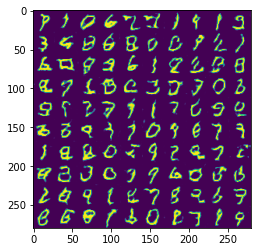

Epoch: 0/30, Step: 1500, D Loss: 0.7848825454711914, G Loss: 0.8803988695144653
Epoch: 1/30, Step: 2000, D Loss: 0.5049947500228882, G Loss: 1.4148976802825928


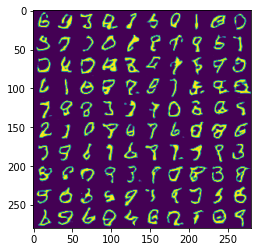

Epoch: 1/30, Step: 2500, D Loss: 1.1205227375030518, G Loss: 0.6510339975357056
Epoch: 2/30, Step: 3000, D Loss: 0.37297824025154114, G Loss: 2.5384860038757324


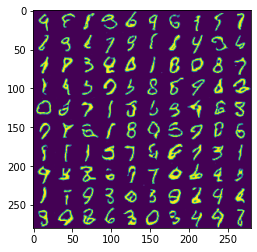

Epoch: 2/30, Step: 3500, D Loss: 0.6905831098556519, G Loss: 1.4759938716888428
Epoch: 3/30, Step: 4000, D Loss: 0.6562768220901489, G Loss: 1.8426358699798584


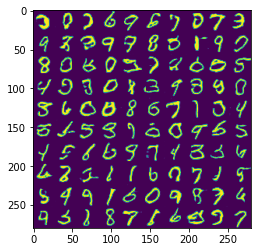

Epoch: 3/30, Step: 4500, D Loss: 0.8893158435821533, G Loss: 1.2010955810546875
Epoch: 4/30, Step: 5000, D Loss: 0.46922987699508667, G Loss: 2.962099075317383


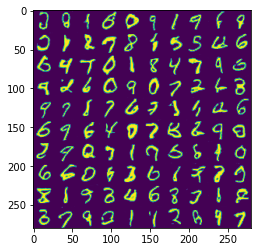

Epoch: 4/30, Step: 5500, D Loss: 0.5035063624382019, G Loss: 2.3149821758270264
Epoch: 5/30, Step: 6000, D Loss: 0.4797043204307556, G Loss: 1.8940644264221191


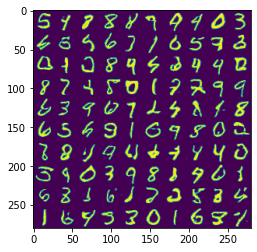

Epoch: 5/30, Step: 6500, D Loss: 0.4487282633781433, G Loss: 2.1170873641967773
Epoch: 6/30, Step: 7000, D Loss: 0.814777672290802, G Loss: 2.8693671226501465


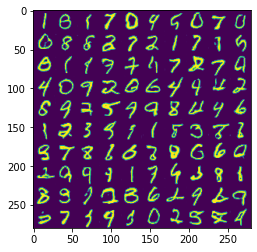

Epoch: 6/30, Step: 7500, D Loss: 0.4786597490310669, G Loss: 2.033107280731201
Epoch: 7/30, Step: 8000, D Loss: 0.5025522112846375, G Loss: 1.8342759609222412


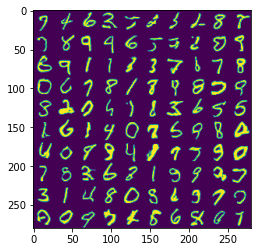

Epoch: 8/30, Step: 8500, D Loss: 0.29292672872543335, G Loss: 1.6527392864227295
Epoch: 8/30, Step: 9000, D Loss: 0.2309967279434204, G Loss: 2.6591038703918457


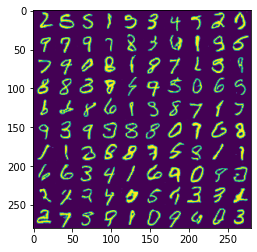

Epoch: 9/30, Step: 9500, D Loss: 0.5236639380455017, G Loss: 2.5449018478393555
Epoch: 9/30, Step: 10000, D Loss: 0.6600860357284546, G Loss: 0.6896138191223145


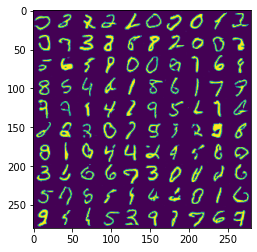

Epoch: 10/30, Step: 10500, D Loss: 0.800955057144165, G Loss: 3.3134074211120605
Epoch: 10/30, Step: 11000, D Loss: 0.8140307664871216, G Loss: 2.9242100715637207


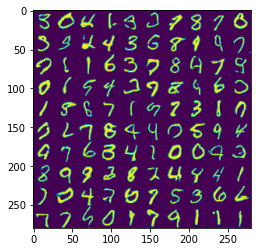

Epoch: 11/30, Step: 11500, D Loss: 0.28797459602355957, G Loss: 2.321819305419922
Epoch: 11/30, Step: 12000, D Loss: 0.2590789496898651, G Loss: 1.8096071481704712


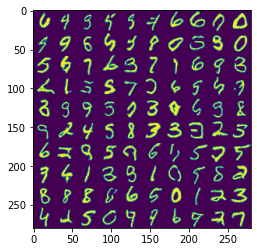

Epoch: 12/30, Step: 12500, D Loss: 0.6086268424987793, G Loss: 3.9196722507476807
Epoch: 12/30, Step: 13000, D Loss: 0.30514296889305115, G Loss: 3.213602066040039


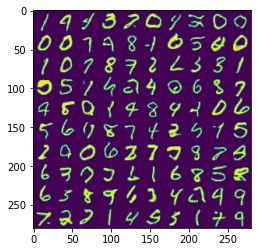

Epoch: 13/30, Step: 13500, D Loss: 0.42379897832870483, G Loss: 0.9949395656585693
Epoch: 13/30, Step: 14000, D Loss: 0.3972196578979492, G Loss: 2.361274003982544


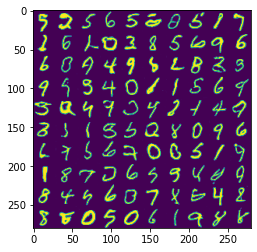

Epoch: 14/30, Step: 14500, D Loss: 0.44784367084503174, G Loss: 0.8857799768447876
Epoch: 14/30, Step: 15000, D Loss: 0.5907126665115356, G Loss: 1.1101667881011963


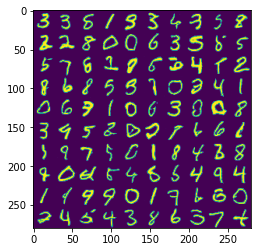

Epoch: 15/30, Step: 15500, D Loss: 0.5113688707351685, G Loss: 2.054443359375
Epoch: 16/30, Step: 16000, D Loss: 0.28128504753112793, G Loss: 1.7655118703842163


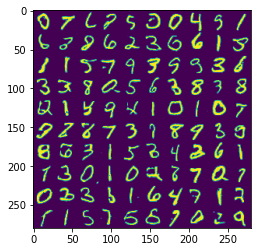

Epoch: 16/30, Step: 16500, D Loss: 0.6762440800666809, G Loss: 1.7668288946151733
Epoch: 17/30, Step: 17000, D Loss: 0.4616641104221344, G Loss: 1.576271414756775


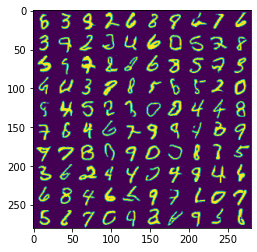

Epoch: 17/30, Step: 17500, D Loss: 0.45536500215530396, G Loss: 3.2801058292388916
Epoch: 18/30, Step: 18000, D Loss: 0.1523299366235733, G Loss: 2.744997501373291


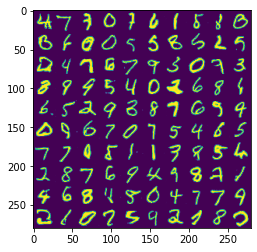

Epoch: 18/30, Step: 18500, D Loss: 0.37100711464881897, G Loss: 2.3054347038269043
Epoch: 19/30, Step: 19000, D Loss: 0.47420158982276917, G Loss: 2.378805160522461


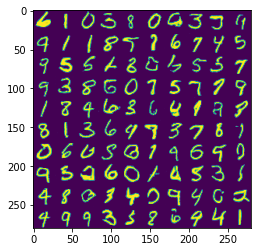

Epoch: 19/30, Step: 19500, D Loss: 0.2658842206001282, G Loss: 3.2664072513580322
Epoch: 20/30, Step: 20000, D Loss: 0.3442646563053131, G Loss: 1.976348876953125


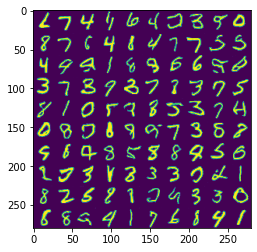

Epoch: 20/30, Step: 20500, D Loss: 0.2870435416698456, G Loss: 2.369229793548584
Epoch: 21/30, Step: 21000, D Loss: 0.310441792011261, G Loss: 3.5422353744506836


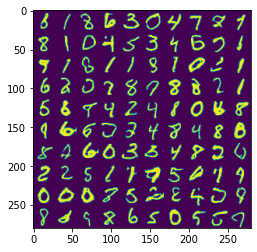

Epoch: 21/30, Step: 21500, D Loss: 0.5975292921066284, G Loss: 1.2565743923187256
Epoch: 22/30, Step: 22000, D Loss: 0.3463679254055023, G Loss: 3.336305856704712


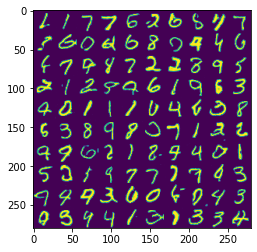

Epoch: 22/30, Step: 22500, D Loss: 0.7665391564369202, G Loss: 1.200871467590332
Epoch: 23/30, Step: 23000, D Loss: 0.29397109150886536, G Loss: 4.421990394592285


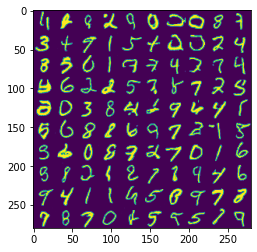

Epoch: 24/30, Step: 23500, D Loss: 0.5184756517410278, G Loss: 3.270779848098755
Epoch: 24/30, Step: 24000, D Loss: 0.7228204011917114, G Loss: 2.271216869354248


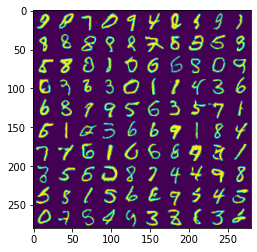

Epoch: 25/30, Step: 24500, D Loss: 0.5057474970817566, G Loss: 2.7831156253814697
Epoch: 25/30, Step: 25000, D Loss: 0.3325449824333191, G Loss: 2.4845781326293945


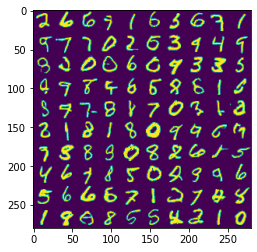

Epoch: 26/30, Step: 25500, D Loss: 1.4280325174331665, G Loss: 4.221629619598389
Epoch: 26/30, Step: 26000, D Loss: 0.5519729852676392, G Loss: 1.6932730674743652


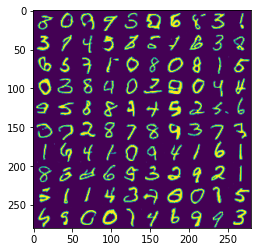

Epoch: 27/30, Step: 26500, D Loss: 0.494069904088974, G Loss: 2.733689069747925
Epoch: 27/30, Step: 27000, D Loss: 0.46739208698272705, G Loss: 3.046288013458252


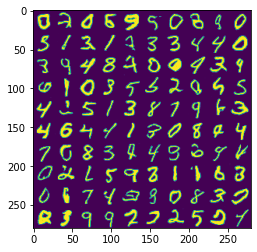

Epoch: 28/30, Step: 27500, D Loss: 0.22615540027618408, G Loss: 3.6408016681671143
Epoch: 28/30, Step: 28000, D Loss: 0.17875488102436066, G Loss: 2.924365997314453


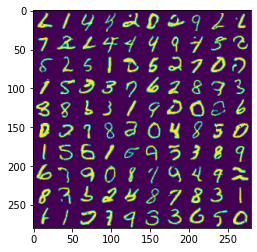

Epoch: 29/30, Step: 28500, D Loss: 0.3246670961380005, G Loss: 3.3524158000946045
Epoch: 29/30, Step: 29000, D Loss: 0.17160682380199432, G Loss: 3.8006749153137207


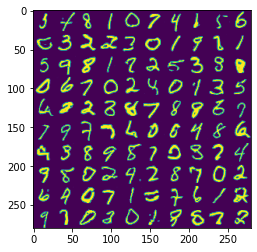

In [19]:
for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_labels)

            D.zero_grad()
            G.zero_grad()
            G_loss.backward()
            G_opt.step()
        
        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))
        
        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, n_noise)
            imshow(img)
            show()
            G.train()
        step += 1

## Sample

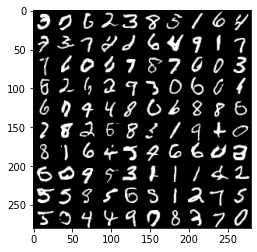

In [20]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')

In [ ]:
def save_checkpoint(state, file_name='checkpoint.pth.tar'):
    torch.save(state, file_name)

In [ ]:
# Saving params.
# torch.save(D.state_dict(), 'D_c.pkl')
# torch.save(G.state_dict(), 'G_c.pkl')
save_checkpoint({'epoch': epoch + 1, 'state_dict':D.state_dict(), 'optimizer' : D_opt.state_dict()}, 'D_dc.pth.tar')
save_checkpoint({'epoch': epoch + 1, 'state_dict':G.state_dict(), 'optimizer' : G_opt.state_dict()}, 'G_dc.pth.tar')